# Обработка пропусков и выбросов в процессе первичного анализа статистики

### Disclaimer: 
_Представленные ниже примеры предназначены исключительно для демонстрации подходов к устранению аномалий в данных. Выбор подхода в "боевых условиях" должен осуществляеться в соответсвии с решаемыми задачами и с учетом особенностей формирования данных в исследуемом процессе_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Загрузка датасета

In [2]:
data = pd.read_csv("iris.csv")
data.tail(7)

,sepal.length,sepal.width,petal.length,petal.width,variety
143,6.8,3.2,5.9,2.3,Virginica
144,6.7,3.3,5.7,2.5,Virginica
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica
149,5.9,3.0,5.1,1.8,Virginica


### Добавляем немного NaN

In [3]:
data["petal.width"].iloc[145:149] = None
data.tail(7)

,sepal.length,sepal.width,petal.length,petal.width,variety
143,6.8,3.2,5.9,2.3,Virginica
144,6.7,3.3,5.7,2.5,Virginica
145,6.7,3.0,5.2,NaN,Virginica
146,6.3,2.5,5.0,NaN,Virginica
147,6.5,3.0,5.2,NaN,Virginica
148,6.2,3.4,5.4,NaN,Virginica
149,5.9,3.0,5.1,1.8,Virginica


## Построение гистограммы "petal.length"

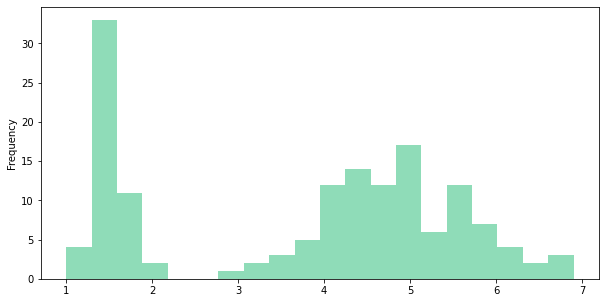

In [4]:
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### Есть выброс "petal.length" в диапазоне примерно 1..1.9

### Зафиксируем исходные данные до заполнения NaN 

In [5]:
with_outliers = data["petal.length"].head(20).copy()
before_NaN = data["petal.width"].iloc[25:42].copy()

### Заменяем  выброс "petal.length" расчетными данными

#### длина лепестка не может быть отрицательной!

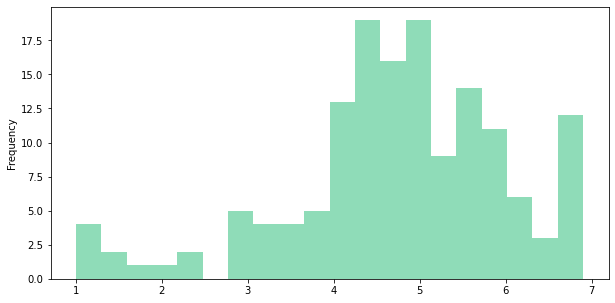

In [6]:
data["petal.length"][data["petal.length"]<=2.8] = np.clip(np.random.normal(loc= data["petal.length"][data["petal.length"]>=2.8].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]<=2.8])), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [ ]:
### снова выбросы :-(
### убираем выброс минимумов ...

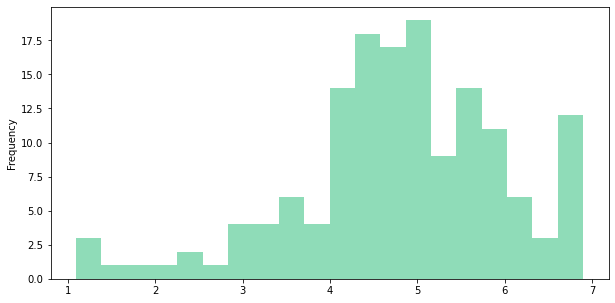

In [7]:
data["petal.length"][data["petal.length"]==data["petal.length"].min()] = np.clip(np.random.normal(loc= data["petal.length"].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]==data["petal.length"].min()]) ), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())



data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### ... и убираем выброс максимумов 

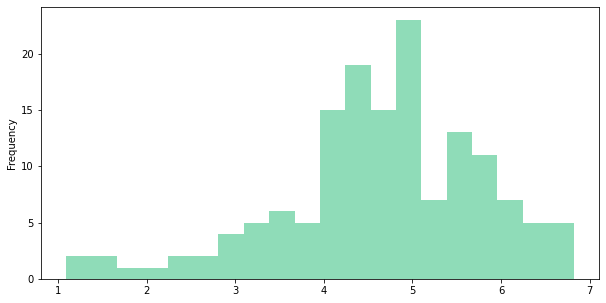

In [8]:
data["petal.length"][data["petal.length"]==data["petal.length"].max()] = np.clip(np.random.normal(loc= data["petal.length"].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]==data["petal.length"].max()]) ), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [9]:
display(pd.DataFrame(list(zip(with_outliers, data["petal.length"].head(20))),
                   columns=["With_outliers", "After_norm"]))

,With_outliers,After_norm
0,1.4,4.438368
1,1.4,2.457126
2,1.3,5.952519
3,1.5,6.091513
4,1.4,2.775278
5,1.7,2.882705
6,1.4,2.931848
7,1.5,3.032698
8,1.4,4.814700
9,1.5,4.832907


###### Выброс исчез

## Построение гистограмы для "petal.width"

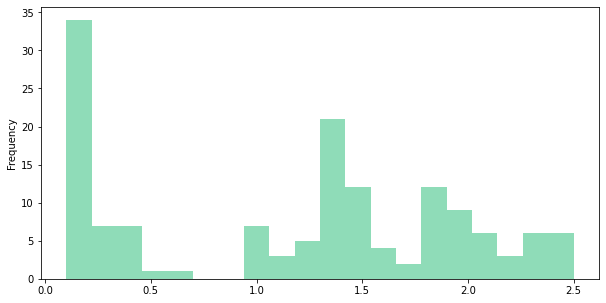

In [10]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### убеждаемся в наличии NaN

In [11]:
data["petal.width"][data["petal.width"].isnull()]

145   NaN
146   NaN
147   NaN
148   NaN
Name: petal.width, dtype: float64

### Заполняем пропуски

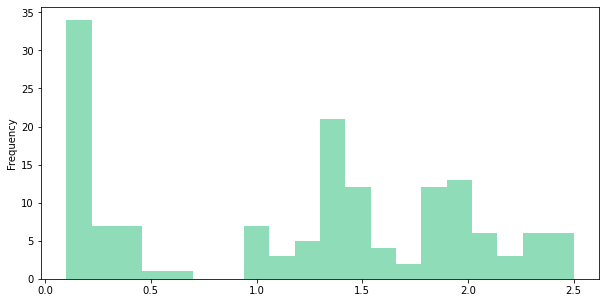

In [12]:
# используем std()
data["petal.width"].fillna(data["petal.width"].mean() 
                           + data["petal.width"].std()*np.random.randint(low=-1, high=2, size=1)[0], # ограничиваем отклонение
                          inplace=True)
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [13]:
data["petal.width"].tail(7)

143    2.300000
144    2.500000
145    1.930193
146    1.930193
147    1.930193
148    1.930193
149    1.800000
Name: petal.width, dtype: float64

### добавим еще пропусков (примерно 1/6)
### и проверим результаты по критерию $\chi^2$

array([21.,  5.,  5.,  1.,  1.,  0.,  0.,  7.,  3.,  5., 20., 11.,  3.,
        2.,  7., 11.,  5.,  2.,  5.,  5.])

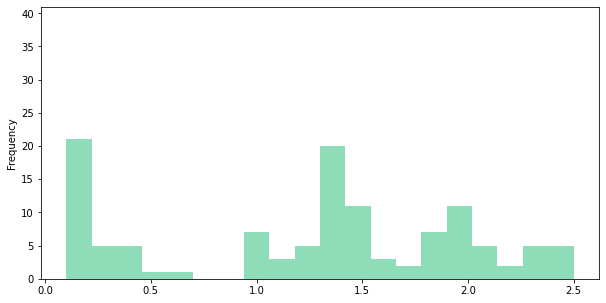

In [14]:
data["petal.width"].iloc[125:139] = None
data["petal.width"].iloc[25:42] = None
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

# фиксируем значения гистограммы (с разными BINS)
b_before, n_before, _ = plt.hist(data["petal.width"], bins=20, visible=False);
b2 = 5
b_before_2, n_before_2, _ = plt.hist(data["petal.width"], bins=b2, visible=False);

# значения столбиков гистограммы
b_before

In [15]:
data["petal.width"].iloc[25:42]

25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
34   NaN
35   NaN
36   NaN
37   NaN
38   NaN
39   NaN
40   NaN
41   NaN
Name: petal.width, dtype: float64

### Подготовка корректирующих значений

In [16]:
df_corr = pd.DataFrame(np.random.normal(loc=data["petal.width"].mean(),
                                scale=data["petal.width"].var(), 
                                size=len(data["petal.width"])),
                      columns = ["petal.width"]) 
                                
df_corr                      

,petal.width
0,1.318792
1,0.607017
2,1.332192
3,1.158110
4,0.126433
...,...
145,0.913398
146,1.259281
147,1.365859
148,1.019666


In [17]:
df_corr.min() # больше нуля :-)

petal.width    0.126433
dtype: float64

### Заполняем пропуски

In [18]:
data.fillna(value=df_corr, inplace=True)
display(pd.DataFrame(list(zip(before_NaN, data["petal.width"].iloc[25:42])),
                   columns=["before_set_NaN", "After_filling"]))

,before_set_NaN,After_filling
0,0.2,1.822041
1,0.4,1.079725
2,0.2,1.428963
3,0.2,1.006637
4,0.2,1.100794
5,0.2,1.236513
6,0.4,2.011737
7,0.1,1.053222
8,0.2,1.688986
9,0.2,1.379600


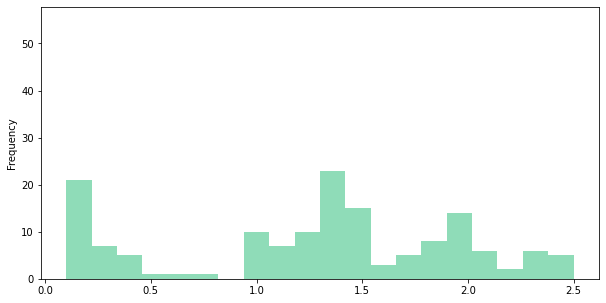

In [19]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20, );
# получаем параметры гистограммы c bins = 20
b_after, n_after, _ = plt.hist(data["petal.width"], bins=20, visible=False);
# и bins = b2
b_after_2, n_after_2, _ = plt.hist(data["petal.width"], bins=b2, visible=False);

### Почти похоже на исходный :-)

#### ... но так ли это
#### используем критерий $\chi^2$

In [20]:
import scipy
scipy.__version__

'1.6.3'

In [21]:
# сравниваем методом хи-квадрат
from scipy.stats import chisquare, chi2_contingency
print (f"ДО\n {b_before} \nПОСЛЕ\n {b_after}")
_, p_value = chisquare(b_before, b_after, ddof=len(b_after)-1)

print(f"p_value = {p_value}")

ДО
 [21.  5.  5.  1.  1.  0.  0.  7.  3.  5. 20. 11.  3.  2.  7. 11.  5.  2.
  5.  5.] 
ПОСЛЕ
 [21.  7.  5.  1.  1.  1.  0. 10.  7. 10. 23. 15.  3.  5.  8. 14.  6.  2.
  6.  5.]
p_value = nan


#### меняем bins

In [22]:
print (f"ДО\n {b_before_2} \nПОСЛЕ\n {b_after_2}")
#stat, p_value_2, dof, _= chi2_contingency([b_before_2, b_after_2])
_, p_value_2 = chisquare(b_before_2, b_after_2, ddof=len(b_after_2)-1)

print(f"p_value = {p_value_2}")

ДО
 [32.  8. 39. 23. 17.] 
ПОСЛЕ
 [34. 12. 55. 30. 19.]
p_value = nan


#### _...нужен иной подход ?_


### Снова генерируем пропуски, но в этот раз удаляем 

In [23]:
data["petal.width"].iloc[125:147] = None
data.tail(10)

,sepal.length,sepal.width,petal.length,petal.width,variety
140,6.7,3.1,5.6,NaN,Virginica
141,6.9,3.1,5.1,NaN,Virginica
142,5.8,2.7,5.1,NaN,Virginica
143,6.8,3.2,5.9,NaN,Virginica
144,6.7,3.3,5.7,NaN,Virginica
145,6.7,3.0,5.2,NaN,Virginica
146,6.3,2.5,5.0,NaN,Virginica
147,6.5,3.0,5.2,1.930193,Virginica
148,6.2,3.4,5.4,1.930193,Virginica
149,5.9,3.0,5.1,1.800000,Virginica


In [24]:
data.dropna(inplace=True)
data.tail(10)

,sepal.length,sepal.width,petal.length,petal.width,variety
118,7.7,2.6,3.38363,2.300000,Virginica
119,6.0,2.2,5.00000,1.500000,Virginica
120,6.9,3.2,5.70000,2.300000,Virginica
121,5.6,2.8,4.90000,2.000000,Virginica
122,7.7,2.8,6.70000,2.000000,Virginica
123,6.3,2.7,4.90000,1.800000,Virginica
124,6.7,3.3,5.70000,2.100000,Virginica
147,6.5,3.0,5.20000,1.930193,Virginica
148,6.2,3.4,5.40000,1.930193,Virginica
149,5.9,3.0,5.10000,1.800000,Virginica


### "Пропали" все строки с пропусками

## Заполняем смешанные пропуски
#### ...но сначала их создадим ))

In [25]:
display(data.head())
data.iloc[0:3] = None
display(data.head())

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,4.438368,0.2,Setosa
1,4.9,3.0,2.457126,0.2,Setosa
2,4.7,3.2,5.952519,0.2,Setosa
3,4.6,3.1,6.091513,0.2,Setosa
4,5.0,3.6,2.775278,0.2,Setosa


,sepal.length,sepal.width,petal.length,petal.width,variety
0,NaN,NaN,NaN,NaN,None
1,NaN,NaN,NaN,NaN,None
2,NaN,NaN,NaN,NaN,None
3,4.6,3.1,6.091513,0.2,Setosa
4,5.0,3.6,2.775278,0.2,Setosa


In [26]:
values = {"sepal.length": data["sepal.length"][data["variety"]=="Setosa"].mean(),
          "sepal.width": data["sepal.width"][data["variety"]=="Setosa"].mean(), 
          "petal.length": data["petal.length"][data["variety"]=="Setosa"].median(), 
          "petal.width": data["petal.width"][data["variety"]=="Setosa"].median(),
          "variety": "Setosa"}
data.fillna(value=values, inplace=True)
display(data.head())

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.012766,3.440426,4.506591,0.3,Setosa
1,5.012766,3.440426,4.506591,0.3,Setosa
2,5.012766,3.440426,4.506591,0.3,Setosa
3,4.600000,3.100000,6.091513,0.2,Setosa
4,5.000000,3.600000,2.775278,0.2,Setosa


## Extra case. Infinity

In [27]:
data["petal.width"].iloc[15:19] = np.array((np.inf, -np.inf, np.inf, np.log(0)))
data.iloc[15:19]

,sepal.length,sepal.width,petal.length,petal.width,variety
15,5.7,4.4,3.324474,inf,Setosa
16,5.4,3.9,5.367584,-inf,Setosa
17,5.1,3.5,4.600904,inf,Setosa
18,5.7,3.8,1.749077,-inf,Setosa


### Гистограмма не строится при наличии inf

In [28]:
data["petal.width"].describe()

count    128.000
mean         NaN
std          NaN
min         -inf
25%        0.575
50%        1.300
75%        1.725
max          inf
Name: petal.width, dtype: float64

In [29]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );
# Ой! Что-то пойшло не так!

ValueError: autodetected range of [-inf, inf] is not finite

## Заменяем inf и -inf на NaN

In [30]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.iloc[14:20]

,sepal.length,sepal.width,petal.length,petal.width,variety
14,5.8,4.0,2.083479,0.2,Setosa
15,5.7,4.4,3.324474,NaN,Setosa
16,5.4,3.9,5.367584,NaN,Setosa
17,5.1,3.5,4.600904,NaN,Setosa
18,5.7,3.8,1.749077,NaN,Setosa
19,5.1,3.8,5.764643,0.3,Setosa


### а дальше дело техники...

# Устранение пропусков в линиях/рядах

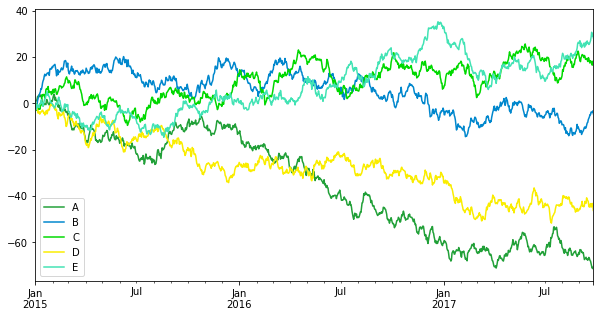

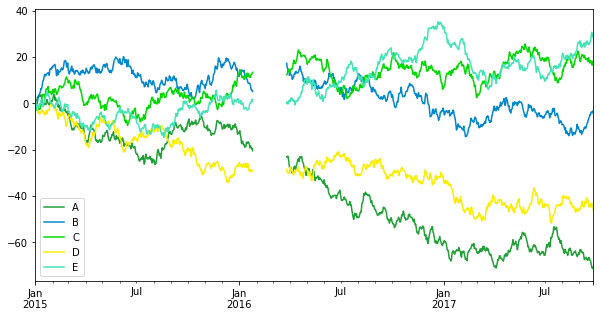

In [31]:
sbercolors = ['#21A038','#0087CD','#00D900', '#FAED00',  '#42E3B4','#21BA72'] 
image_params = dict(figsize=(10,5), 
                color=sbercolors)
samples = np.random.randn(1000, 5)

df = pd.DataFrame(samples, 
                   index=pd.date_range("1/1/2015", periods=1000),
                   columns=list("ABCDE"))
df = df.cumsum()
df.plot(**image_params);    
before = df.iloc[400:420].copy()        
df.iloc[390:450] = None

df.plot(**image_params);
  

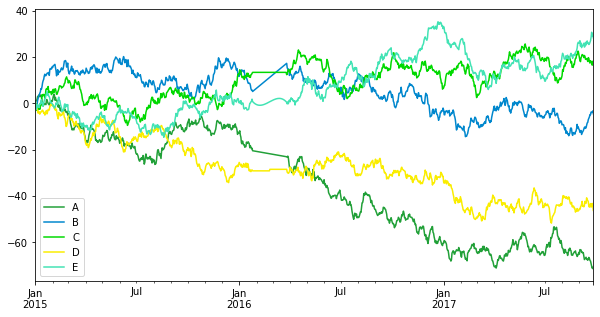

In [32]:
to_fill = {"A": df["A"].interpolate(method='linear'),
           "B": df["B"].interpolate(method='time'),
           "C": df["C"].interpolate(method='pad'),
           "D": df["D"].interpolate(method='nearest'),
           "E": df["E"].interpolate(method='akima'),}
df.fillna(value=to_fill, inplace=True)
df.plot(**image_params);


In [33]:
to_check = pd.concat((before,df.iloc[400:420]), axis=1)
to_check.columns = pd.MultiIndex.from_product([['Before', 'Recycled'], df.columns,],
                                     names=['subject', 'type'])

display(to_check) 

subject        Before                                             Recycled  \
type                A          B         C          D         E          A   
2016-02-05 -19.651666   4.928745  9.105983 -25.548039  1.252605 -20.921577   
2016-02-06 -18.451035   4.650275  8.900118 -23.725948  1.702784 -20.964336   
2016-02-07 -18.426057   4.878691  9.637650 -23.228972  2.602156 -21.007095   
2016-02-08 -18.503113   5.462301  6.101220 -22.515319  3.520087 -21.049854   
2016-02-09 -18.040260   6.872964  6.233329 -23.141103  2.907203 -21.092613   
2016-02-10 -18.331130   6.403464  4.531250 -23.896169  3.145539 -21.135372   
2016-02-11 -18.309021   5.677185  5.230086 -22.880067  1.979935 -21.178131   
2016-02-12 -17.944700   6.962909  5.901468 -23.913284  2.714906 -21.220890   
2016-02-13 -18.846045   6.187935  4.835284 -24.309831  4.278964 -21.263649   
2016-02-14 -17.431170   6.579217  4.611326 -24.701723  3.989787 -21.306408   
2016-02-15 -17.715013   6.655617  3.248895 -25.888622  4.007674 -21.349167   
2016-02-16 -17.904085   7.912373 -0.619603 -26.436664  4.763201 -21.391926   
2016-02-17 -19.474534   8.617505  0.000671 -25.722671  3.888643 -21.434685   
2016-02-18 -19.532052   8.558631  0.573472 -23.990603  5.013740 -21.477444   
2016-02-19 -19.992067   9.460828  1.363784 -24.164111  5.731998 -21.520203   
2016-02-20 -19.959413   8.648675  2.546301 -24.645553  4.610353 -21.562962   
2016-02-21 -20.985335   9.924836  2.163158 -23.051611  3.874109 -21.605721   
2016-02-22 -19.992987  11.220890  2.520070 -23.310119  3.058331 -21.648480   
2016-02-23 -21.956431  12.302543  2.368855 -24.629350  2.867634 -21.691239   
2016-02-24 -22.568825  12.815947  2.345748 -26.663367  2.114058 -21.733998   

subject                                                
type                B          C          D         E  
2016-02-05   7.348853  13.426222 -29.153303 -0.771239  
2016-02-06   7.548512  13.426222 -29.153303 -0.796495  
2016-02-07   7.748170  13.426222 -29.153303 -0.805814  
2016-02-08   7.947829  13.426222 -29.153303 -0.800062  
2016-02-09   8.147488  13.426222 -29.153303 -0.780107  
2016-02-10   8.347146  13.426222 -29.153303 -0.746817  
2016-02-11   8.546805  13.426222 -29.153303 -0.701059  
2016-02-12   8.746464  13.426222 -29.153303 -0.643700  
2016-02-13   8.946122  13.426222 -29.153303 -0.575609  
2016-02-14   9.145781  13.426222 -29.153303 -0.497652  
2016-02-15   9.345440  13.426222 -29.153303 -0.410697  
2016-02-16   9.545098  13.426222 -29.153303 -0.315612  
2016-02-17   9.744757  13.426222 -29.153303 -0.213263  
2016-02-18   9.944415  13.426222 -29.153303 -0.104519  
2016-02-19  10.144074  13.426222 -29.153303  0.009753  
2016-02-20  10.343733  13.426222 -29.153303  0.128685  
2016-02-21  10.543391  13.426222 -29.153303  0.251411  
2016-02-22  10.743050  13.426222 -29.153303  0.377063  
2016-02-23  10.942709  13.426222 -29.153303  0.504773  
2016-02-24  11.142367  13.426222 -29.153303  0.633673

#### Проверим точность восстановления по критерию $\chi^2$

In [34]:
for litera in "ABCDE":
    stat, p_value = chisquare([to_check["Before", litera].abs(),  ## Только положительные заначения!!!
                               to_check["Recycled",litera].abs()])
    display(f"{litera}: {np.mean(p_value)}") 

'A: 0.7264275882153401'

'B: 0.6447775320104071'

'C: 0.08198703909911856'

'D: 0.5129982406085043'

'E: 0.2142005672436243'

#### или просто посчитаем погрешность

In [35]:
# set colors for min, max. average values
color_set = pd.DataFrame({"Colors":("MAX", "MIN", "AVERAGE")})

def highlight_fill(s):
    colors =  ['background-color: #42E3B4',
            'background-color: #0087CD',
             'background-color: #FAED00']
    return [colors[0] if i==0 else  colors[1] if i==1 else colors[2] for i in range(len(s))]


color_set = color_set.style.apply(highlight_fill)
display(color_set)

# count accurancy values

accurancy = pd.concat( (before-df.iloc[400:420],
                       pow((before-df.iloc[400:420]),2)), axis=1) 
accurancy.columns = pd.MultiIndex.from_product([['ABS', 'SQR'], df.columns,],
                                     names=['subject', 'type'])
# adding a row
accurancy.loc[-1] = [accurancy[a_s].mean() for a_s in accurancy.columns[:5].tolist()] +\
                    [np.sqrt(accurancy[a_s].sum()/(len(accurancy)-1)) for a_s in accurancy.columns[5:].tolist()]  

def highlight_diff_max(s):
    if max(abs(s))==max(s): 
        idx = s.tolist().index(max(abs(s)))
    elif max(abs(s))!=max(s):
        idx = s.tolist().index(max(s))
    return ['background-color: #42E3B4' if i==idx else '' for i in range(len(s))]

def highlight_diff_min(s):
    if min(abs(s))==min(s): 
        idx = s.tolist().index(min(abs(s)))
    elif min(abs(s))!=min(s):
        idx = s.tolist().index(min(s))
    return ['background-color: #0087CD' if i==idx else '' for i in range(len(s))]

def highlight_last_row(s):
    return ['background-color: #FAED00' if i==len(s)-1 else '' for i in range(len(s))]

accurancy = accurancy.style.apply(highlight_last_row).apply(highlight_diff_max).apply(highlight_diff_min)
accurancy


,Colors
0,MAX
1,MIN
2,AVERAGE


### Красиво сохраняем...

In [36]:
type(accurancy)

pandas.io.formats.style.Styler

In [37]:
accurancy.to_excel("accurancy.xlsx") # xlsx only !!!!!!!!